#LSTM 


**Features:** Open, High, Low, Close, Volume (last 60 days lookback).

In [12]:
# !pip install yfinance --quiet
# !pip install tensorflow --quiet
# !pip install joblib --quiet

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

pd.options.display.max_columns = 50
pd.options.display.width = 120

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def closeness_accuracy(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    eps = 1e-8
    closeness = 1 - (np.abs(y_true - y_pred) / (np.abs(y_true) + eps))
    return np.mean(closeness) * 100

def plot_actual_vs_predicted(dates, y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(12,5))
    plt.plot(dates, y_true, label='Actual')
    plt.plot(dates, y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
# Download data
TICKER = input('Enter stock ticker (e.g., AAPL or RELIANCE.NS): ').strip().upper()
YEARS = 10
start_date = (datetime.datetime.now() - datetime.timedelta(days=YEARS*365)).strftime('%Y-%m-%d')
print(f'Downloading {TICKER} from {start_date} to today...')
df = yf.download(TICKER, start=start_date, progress=False)
if df.empty:
    raise ValueError('No data returned for ticker. Check symbol or network')
df = df[['Open','High','Low','Close','Volume']].copy()
df.index = pd.to_datetime(df.index)
print('Rows downloaded:', len(df))
df.tail()

C:\Users\AFNAN PASHA\AppData\Local\Temp\ipykernel_30076\761655137.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=start_date, progress=False)


Rows downloaded: 2468


Price,Open,High,Low,Close,Volume
Ticker,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS,GAIL.NS
Date,,,,,
2025-11-03,182.440002,184.440002,177.839996,183.690002,11050075
2025-11-04,183.979996,184.490005,180.750000,181.619995,11320462
2025-11-05,181.619995,181.619995,181.619995,181.619995,0
2025-11-06,182.800003,182.800003,178.649994,178.979996,8609714
2025-11-07,178.300003,179.889999,177.160004,179.570007,2059294


In [16]:
# Feature scaling and sequence creation
FEATURES = ['Open','High','Low','Close','Volume']
lookback = 60  # days

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[FEATURES]), columns=FEATURES, index=df.index)

# Build sequences X (lookback days) -> y (next day's Close)
X = []
y = []
dates = []
for i in range(lookback, len(df_scaled)):
    X.append(df_scaled.iloc[i-lookback:i].values)
    y.append(df_scaled['Close'].iloc[i])
    dates.append(df_scaled.index[i])
X = np.array(X)
y = np.array(y)

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (2408, 60, 5)
y shape: (2408,)


In [17]:
# Train/test split (time-aware)
train_size = 0.8
split = int(len(X) * train_size)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_test = dates[split:]

print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Train samples: 1926 Test samples: 482


In [18]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\AFNAN PASHA\.anaconda\Anaconda compiler\envs\tf_new\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0039 - val_loss: 3.5302e-04
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.1793e-04 - val_loss: 7.7687e-04
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7.2358e-04 - val_loss: 0.0025
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.9287e-04 - val_loss: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.4901e-04 - val_loss: 4.8693e-04
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 4.9972e-04 - val_loss: 0.0021
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 4.1975e-04 - val_loss: 0.0014
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 3.8811e-04 - val_loss: 0.0018
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 3.6264e-04 - val_loss: 0.0014
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 3.7013e-04 - val_loss: 7.5057e-04
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 3.3564e-04 - val_loss: 8.4

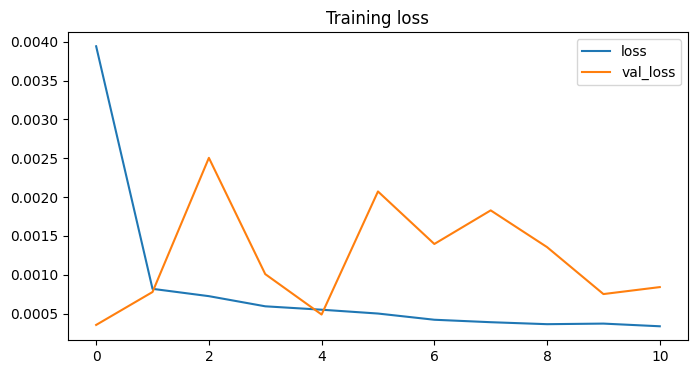

In [19]:
# Train with EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)

# plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training loss')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
R2: 0.6936747865796016
RMSE: 12.206587772114846
MAE: 9.862657597151562
Closeness Accuracy (%): 94.80981741873347


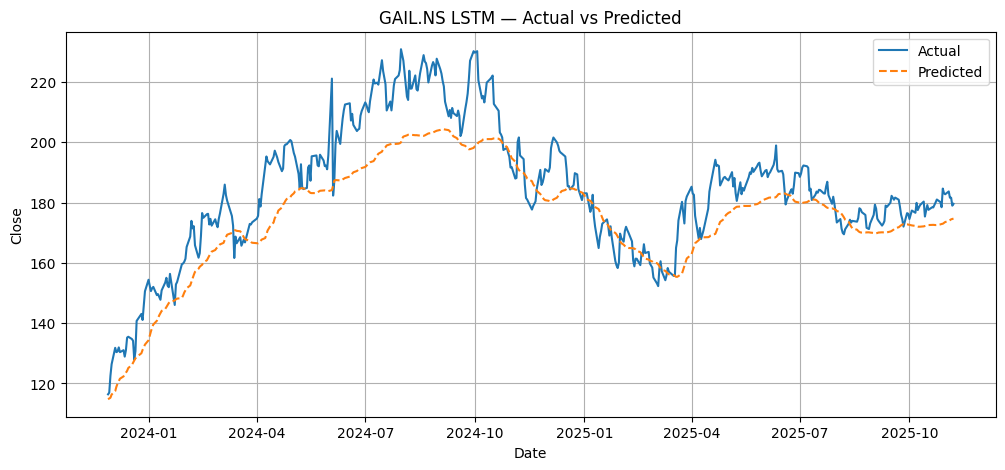

In [20]:
# Predict on test set
y_pred_scaled = model.predict(X_test).reshape(-1)

# Inverse scale to original Close prices
# To inverse transform, we need full feature vector; create placeholders where Close is predicted and other features are from last row of each sequence
inv_y_test = []
inv_y_pred = []
for i in range(len(y_test)):
    # true
    last_seq = X_test[i][-1].copy()
    # for true: replace Close scaled with actual scaled y_test[i]
    true_scaled = y_test[i]
    temp = last_seq.copy()
    temp[3] = true_scaled  # index 3 = Close in FEATURES ordering
    inv_true = scaler.inverse_transform(temp.reshape(1,-1))[0][3]
    inv_y_test.append(inv_true)
    # predicted
    temp2 = last_seq.copy()
    temp2[3] = y_pred_scaled[i]
    inv_pred = scaler.inverse_transform(temp2.reshape(1,-1))[0][3]
    inv_y_pred.append(inv_pred)

inv_y_test = np.array(inv_y_test)
inv_y_pred = np.array(inv_y_pred)

r2 = r2_score(inv_y_test, inv_y_pred)
rmse_val = rmse(inv_y_test, inv_y_pred)
mae_val = mean_absolute_error(inv_y_test, inv_y_pred)
close_acc = closeness_accuracy(inv_y_test, inv_y_pred)

print('R2:', r2)
print('RMSE:', rmse_val)
print('MAE:', mae_val)
print('Closeness Accuracy (%):', close_acc)

plot_actual_vs_predicted(dates_test, inv_y_test, inv_y_pred, title=f'{TICKER} LSTM — Actual vs Predicted')

In [21]:
# Predict today's and tomorrow's close
# Use the last available sequence for next-day prediction
last_seq = df_scaled.values[-lookback:]
last_seq = last_seq.reshape(1, last_seq.shape[0], last_seq.shape[1])
pred_next_scaled = model.predict(last_seq)[0][0]

# inverse transform: build temp vector with predicted close
temp = last_seq[0][-1].copy()
temp[3] = pred_next_scaled
pred_next = scaler.inverse_transform(temp.reshape(1,-1))[0][3]

print(f'Last available date: {df.index[-1].date()}')
print(f'Predicted next trading day CLOSE (tomorrow): {pred_next:.2f}')

# For predicting 'today' close as per the LR model mapping previous day -> today's close,
# we can also predict the close for last available date by using sequence before last
if len(df_scaled) > lookback:
    seq_for_last = df_scaled.values[-lookback-1:-1].reshape(1, lookback, len(FEATURES))
    pred_for_last_scaled = model.predict(seq_for_last)[0][0]
    temp2 = seq_for_last[0][-1].copy()
    temp2[3] = pred_for_last_scaled
    pred_for_last = scaler.inverse_transform(temp2.reshape(1,-1))[0][3]
    print(f'Predicted CLOSE for last available date ({df.index[-1].date()}): {pred_for_last:.2f}')
else:
    print('Not enough data to predict last date close separately')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Last available date: 2025-11-07
Predicted next trading day CLOSE (tomorrow): 174.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted CLOSE for last available date (2025-11-07): 174.68


In [22]:
# Save model
model.save(f'{TICKER}_lstm_model.h5')
print('Saved LSTM model to disk')

Saved LSTM model to disk
